## Description
[Version 11 of this kernel](https://www.kaggle.com/haveri/flowerflowerwhoareyou-onlysubmissions-ensembling?scriptVersionId=32998379) ensembles outputs of 4 other kernels to create a submission for this competition. The 4 kernels used are<br>
S1 - [EfficientNet-With-All-5-Imagesets-S1](https://www.kaggle.com/haveri/efficientnet-with-all-5-imagesets-s1?scriptVersionId=32838132). Uses 1 EfficientNetB7. LR_EXP_DECAY = 0.8.<br>
S2 - Uses 1 EfficientNetB7. LR_EXP_DECAY = 0.75.<br>
S3 - 1 DenseNet201. LR_EXP_DECAY = 0.8.<br>
S4 - 1 DenseNet201. LR_EXP_DECAY = 0.75.<br>

In [1]:
!pip install -q efficientnet

In [2]:
import math, re, gc
import numpy as np # linear algebra
import pickle
from datetime import datetime, timedelta
import tensorflow as tf
import efficientnet.tfkeras as efficientnet
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print('TensorFlow version', tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

TensorFlow version 2.1.0


In [3]:
# !cp /kaggle/input/flowerflowerwhoareyou/submission_012.csv submission.csv
# !cp /kaggle/input/flowerflowerwhoareyou/submission_2.csv submission.csv
# !cp /kaggle/input/efficientnet-with-oxford-images/20200418_1708_submission.csv submission.csv

In [4]:
# !ls -l /kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-512x512/train/
# !ls -l /kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-512x512/val/

In [5]:
# !ls -l /kaggle/input/oxford-flowers-tfrecords/tfrecords-png-512x512/
# !ls -l /kaggle/input/efficientnet-with-oxford-images/20200418_1708_submission.csv

In [6]:
!ls -ltr /kaggle/input/
#!ls -l /kaggle/input/efficientnet-with-oxford-images/
#!ls -l /kaggle/input/efficientnet-with-oxford-images-v2/
#!ls -l /kaggle/input/efficientnet-with-oxford-images-set-3/
#!ls -l /kaggle/input/efficientnet-with-oxford-images-set-4/
#!ls -l /kaggle/input/efficientnet-with-oxford-images/20200424_0516_tests_vals_0.pkl /kaggle/input/efficientnet-with-oxford-images-v2/20200424_0610_tests_vals_0.pkl
#!ls -l /kaggle/input/efficientnet-with-oxford-images/20200424_1055_tests_vals_01.pkl /kaggle/input/efficientnet-with-oxford-images-v2/20200424_1100_tests_vals_01.pkl
#!ls -ltr /kaggle/input/efficientnet-with-oxford-images-set-3/20200424_1609_tests_vals_01.pkl /kaggle/input/efficientnet-with-oxford-images-set-4/20200424_1849_tests_vals_01.pkl
#!ls -ltr /kaggle/input/efficientnet-with-oxford-images/20200425_0903_tests_vals_0.pkl /kaggle/input/efficientnet-with-oxford-images-v2/20200425_1139_tests_vals_0.pkl
#!ls -ltr /kaggle/input/efficientnet-with-all-5-imagesets-s1/20200428_0641_tests_vals_0.pkl /kaggle/input/efficientnet-with-all-5-imagesets-s2/20200428_0931_tests_vals_0.pkl
#!ls -ltr /kaggle/input/densenet-with-all-5-imagesets-s3/20200428_1755_tests_vals_0.pkl /kaggle/input/densenet-with-all-5-imagesets-s4/20200429_0633_tests_vals_0.pkl
#

total 8
drwxr-xr-x 6 nobody nogroup 4096 Feb 10 23:12 flower-classification-with-tpus
drwxr-xr-x 2 nobody nogroup 4096 May 10 05:18 all-previous-4


In [7]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print('Replicas:', strategy.num_replicas_in_sync)

GCS_DS_PATH = KaggleDatasets().get_gcs_path('flower-classification-with-tpus')
print(GCS_DS_PATH)
!ls -ltr $GCS_DS_PATH
GCS_DS_PATH = '/kaggle/input/flower-classification-with-tpus'
print(GCS_DS_PATH)
!ls -ltr $GCS_DS_PATH
#!ls -ltr /kaggle/input/oxford-random-35-flowers-each-of-101-classes

Replicas: 1
gs://kds-00678dcb48cf1620abe5f19efdc3a50cd7949306c3125d21fa910615
ls: cannot access 'gs://kds-00678dcb48cf1620abe5f19efdc3a50cd7949306c3125d21fa910615': No such file or directory
/kaggle/input/flower-classification-with-tpus
total 104
-rw-r--r-- 1 nobody nogroup 88593 Feb 10 23:12 sample_submission.csv
drwxr-xr-x 5 nobody nogroup  4096 Feb 10 23:12 tfrecords-jpeg-512x512
drwxr-xr-x 5 nobody nogroup  4096 Feb 10 23:12 tfrecords-jpeg-331x331
drwxr-xr-x 5 nobody nogroup  4096 Feb 10 23:12 tfrecords-jpeg-224x224
drwxr-xr-x 5 nobody nogroup  4096 Feb 10 23:12 tfrecords-jpeg-192x192


In [8]:
start_time = datetime.now()
print('Time now is', start_time)
end_training_by_tdelta = timedelta(seconds=8400)
this_run_file_prefix = start_time.strftime('%Y%m%d_%H%M_')
print(this_run_file_prefix)

IMAGE_SIZE = [224, 224] # [512, 512]

EPOCHS = 12
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

GCS_PATH_SELECT = {
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')

#print(VALIDATION_FILENAMES)
#print(TRAINING_FILENAMES)

CLASSES = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'wild geranium', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', # 00 - 09
           'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', # 10 - 19
           'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', # 20 - 29
           'carnation', 'garden phlox', 'love in the mist', 'cosmos', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', # 30 - 39
           'barberton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'daisy', 'common dandelion', # 40 - 49
           'petunia', 'wild pansy', 'primula', 'sunflower', 'lilac hibiscus', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia', # 50 - 59
           'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum', 'spring crocus', 'iris', 'windflower', 'tree poppy', # 60 - 69
           'gazania', 'azalea', 'water lily', 'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium', # 70 - 79
           'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen ', 'watercress', 'canna lily', # 80 - 89
           'hippeastrum ', 'bee balm', 'pink quill', 'foxglove', 'bougainvillea', 'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower', # 90 - 99
           'trumpet creeper', 'blackberry lily', 'common tulip', 'wild rose'] # 100 - 102

Time now is 2020-05-11 17:04:15.640579
20200511_1704_


In [9]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [10]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image
#

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'class': tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label
#

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'id': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum
#

def load_dataset(filenames, labeled = True, ordered = False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls = AUTO)
    return dataset
#

def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0, 2)
    return image, label
#

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset
#

def get_validation_dataset(ordered = False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled = True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset
#

def get_test_dataset(ordered = False):
    dataset = load_dataset(TEST_FILENAMES, labeled = False, ordered = ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset
#

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)
#

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))
#

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


In [11]:
# This no longer works. For now commented.

#cmdataset = get_validation_dataset(ordered = True)
#images_ds = cmdataset.map(lambda image, label: image)
#labels_ds = cmdataset.map(lambda image, label: label).unbatch()
#cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()

In [12]:
test_ds = get_test_dataset(ordered = True)

#print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)

## Retrieve Outputs from 4 Trained Kernels

In [13]:
start_time = datetime.now()
this_run_file_prefix = start_time.strftime('%Y%m%d_%H%M_')
start_model = 0
model_indx_0 = start_model
model_indx_1 = start_model + 1
#test_vals_pickle_outputs = ['/kaggle/input/efficientnet-with-oxford-images/20200424_0516_tests_vals_0.pkl', '/kaggle/input/efficientnet-with-oxford-images-v2/20200424_0610_tests_vals_0.pkl']
#test_vals_pickle_outputs = ['/kaggle/input/efficientnet-with-oxford-images-v2/20200424_1100_tests_vals_01.pkl', '/kaggle/input/efficientnet-with-oxford-images/20200424_1055_tests_vals_01.pkl']
#test_vals_pickle_outputs = ['/kaggle/input/efficientnet-with-oxford-images-set-3/20200424_1609_tests_vals_01.pkl', '/kaggle/input/efficientnet-with-oxford-images-set-4/20200424_1849_tests_vals_01.pkl', '/kaggle/input/efficientnet-with-oxford-images/20200425_0903_tests_vals_0.pkl', '/kaggle/input/efficientnet-with-oxford-images-v2/20200425_1139_tests_vals_0.pkl']

# test_vals_pickle_outputs = ['/kaggle/input/efficientnet-with-all-5-imagesets-s1-own/20200504_2220_tests_vals_0.pkl', 
#                             '/kaggle/input/efficientnet-with-all-5-imagesets-s1-own/20200505_0500_tests_vals_0.pkl',
#                             '/kaggle/input/efficientnet-with-all-5-imagesets-s1-own/20200505_1031_tests_vals_0.pkl', 
#                             '/kaggle/input/efficientnet-with-all-5-imagesets-s1-own/20200505_1314_tests_vals_0.pkl']

# test_vals_pickle_outputs = ['/kaggle/input/best-four-weights/20200505_0500_tests_vals_0.pkl', 
#                             '/kaggle/input/version-7/20200507_1449_tests_vals_0.pkl',
#                             '/kaggle/input/best-four-weights/20200505_0752_tests_vals_0.pkl',
#                             '/kaggle/input/best-four-weights/20200505_1031_tests_vals_0.pkl',
#                             '/kaggle/input/best-four-weights/20200505_1314_tests_vals_0.pkl']

# test_vals_pickle_outputs = ['/kaggle/input/all-predictions/20200504_2220_tests_vals_0.pkl', 
#                             '/kaggle/input/all-predictions/20200505_0500_tests_vals_0.pkl',
#                             '/kaggle/input/all-predictions/20200505_0752_tests_vals_0.pkl', 
#                             '/kaggle/input/all-predictions/20200505_1031_tests_vals_0.pkl',
#                             '/kaggle/input/all-predictions/20200505_1314_tests_vals_0.pkl', 
#                             '/kaggle/input/all-predictions/20200507_1449_tests_vals_0.pkl']

test_vals_pickle_outputs = ['/kaggle/input/all-previous-4/97731.pkl',
                            '/kaggle/input/all-previous-4/97606.pkl', 
                            '/kaggle/input/all-previous-4/97611.pkl',
                            '/kaggle/input/all-previous-4/97659.pkl']

In [14]:
def get_results_from_pickle(filename):
    pklfile = open(filename, 'rb')
    test_results = pickle.load(pklfile)
    pklfile.close()
    return test_results
#

In [15]:
no_of_models = len(test_vals_pickle_outputs)
cm_correct_labels_results = [0] * no_of_models
cm_predictions_results = [0] * no_of_models
test_ids_results = [0] * no_of_models
val_probabilities = [0] * no_of_models
test_probabilities = [0] * no_of_models
# test_results = get_results_from_pickle(test_vals_pickle_outputs[0])
# [cm_correct_labels_results[0], cm_predictions_results[0], test_ids_results[0], val_probabilities[0], test_probabilities[0]] = test_results
# test_results = get_results_from_pickle(test_vals_pickle_outputs[1])
# [cm_correct_labels_results[1], cm_predictions_results[1], test_ids_results[1], val_probabilities[1], test_probabilities[1]] = test_results
# test_results = get_results_from_pickle(test_vals_pickle_outputs[2])
# [cm_correct_labels_results[2], cm_predictions_results[2], test_ids_results[2], val_probabilities[2], test_probabilities[2]] = test_results
# test_results = get_results_from_pickle(test_vals_pickle_outputs[3])
# [cm_correct_labels_results[3], cm_predictions_results[3], test_ids_results[3], val_probabilities[3], test_probabilities[3]] = test_results
# test_results = get_results_from_pickle(test_vals_pickle_outputs[4])
# [cm_correct_labels_results[4], cm_predictions_results[4], test_ids_results[4], val_probabilities[4], test_probabilities[4]] = test_results
for i in range(no_of_models):
    test_results = get_results_from_pickle(test_vals_pickle_outputs[i])
    [cm_correct_labels_results[i], cm_predictions_results[i], test_ids_results[i], val_probabilities[i], test_probabilities[i]] = test_results
#

In [16]:
cm_probabilities = np.zeros((val_probabilities[0].shape)) # = val_probabilities[0] + val_probabilities[1] + val_probabilities[2]
for j in range(no_of_models):
    cm_probabilities = cm_probabilities + val_probabilities[j]

cm_predictions = np.argmax(cm_probabilities, axis = -1)
print('Correct labels: ', cm_correct_labels_results[0].shape, cm_correct_labels_results[0])
print('Predicted labels: ', cm_predictions.shape, cm_predictions)

Correct labels:  (3712,) [ 50  13  74 ... 102  48  67]
Predicted labels:  (3712,) [ 50  13  74 ... 102  48  67]


In [17]:
def getFitPrecisionRecall(correct_labels, predictions):
    score = f1_score(correct_labels, predictions, labels = range(len(CLASSES)), average = 'macro')
    precision = precision_score(correct_labels, predictions, labels = range(len(CLASSES)), average = 'macro')
    recall = recall_score(correct_labels, predictions, labels = range(len(CLASSES)), average = 'macro')
    return score, precision, recall
#

In [18]:
for j in range(no_of_models):
    model_predictions = np.argmax(val_probabilities[j], axis = -1)
    score, precision, recall = getFitPrecisionRecall(cm_correct_labels_results[0], model_predictions)
    print('For model: {}, f1 score: {:.4f}, precision: {:.4f}, recall: {:.4f}'.format(j, score, precision, recall))

For model: 0, f1 score: 0.9999, precision: 0.9998, recall: 0.9999
For model: 1, f1 score: 1.0000, precision: 1.0000, recall: 1.0000
For model: 2, f1 score: 0.9996, precision: 0.9996, recall: 0.9997
For model: 3, f1 score: 0.9999, precision: 0.9998, recall: 0.9999


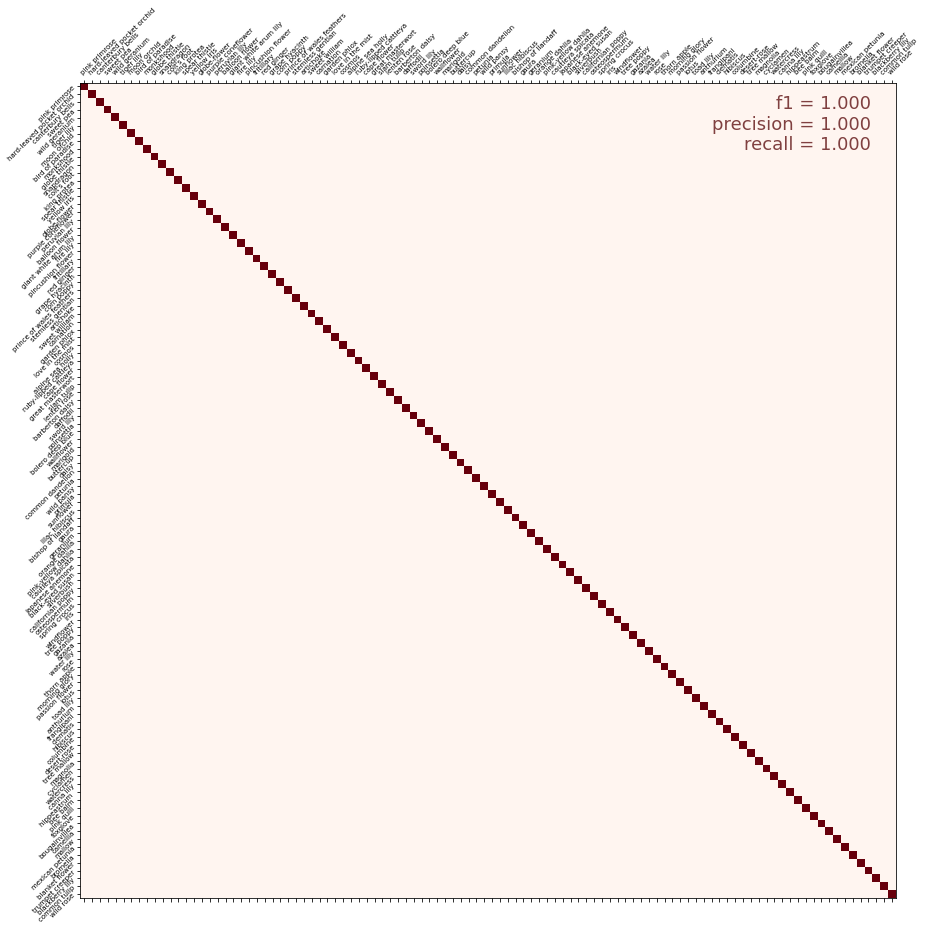

f1 score: 1.000000, precision: 1.000000, recall: 1.000000


In [19]:
cmat = confusion_matrix(cm_correct_labels_results[0], cm_predictions, labels = range(len(CLASSES)))
score, precision, recall = getFitPrecisionRecall(cm_correct_labels_results[0], cm_predictions)
cmat = (cmat.T / cmat.sum(axis = -1)).T
display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.6f}, precision: {:.6f}, recall: {:.6f}'.format(score, precision, recall))

In [20]:
def create_submission_file_not_the_right_way(filename, probabilities, test_ids):
    predictions = np.argmax(probabilities, axis = -1)
    print('Generating submission file...', filename)
    np.savetxt(filename, np.rec.fromarrays([test_ids, predictions]), fmt = ['%s', '%d'], delimiter = ',', header = 'id,label', comments = '')
#
#
def create_submission_file(filename, probabilities):
    predictions = np.argmax(probabilities, axis = -1)
    print('Generating submission file...', filename)
    test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
    test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

    np.savetxt(filename, np.rec.fromarrays([test_ids, predictions]), fmt = ['%s', '%d'], delimiter = ',', header = 'id,label', comments = '')
#
#

In [21]:
def combine_two(correct_labels, probability_0, probability_1):
    print('Start. ', datetime.now())
    alphas0_to_try = np.linspace(0, 1, 101)
    best_score = -1
    best_alpha0 = -1
    best_alpha1 = -1
    best_precision = -1
    best_recall = -1
    best_val_predictions = None

    for alpha0 in alphas0_to_try:
        alpha1 = 1.0 - alpha0
        probabilities = alpha0 * probability_0 + alpha1 * probability_1 #
        predictions = np.argmax(probabilities, axis = -1)

        score, precision, recall = getFitPrecisionRecall(correct_labels, predictions)
        if score > best_score:
            best_alpha0 = alpha0
            best_alpha1 = alpha1
            best_score = score
            best_precision = precision
            best_recall = recall
            best_val_predictions = predictions
    #
    return best_alpha0, best_alpha1, best_val_predictions, best_score, best_precision, best_recall

In [22]:
def combine_three(correct_labels, probability_0, probability_1, probability_2):
    print('Start. ', datetime.now())
    alphas0_to_try = np.linspace(0, 1, 101)
    alphas1_to_try = np.linspace(0, 1, 101)
    best_score = -1
    best_alpha0 = -1
    best_alpha1 = -1
    best_alpha2 = -1
    best_precision = -1
    best_recall = -1
    best_val_predictions = None

    for alpha0 in alphas0_to_try:
        for alpha1 in alphas1_to_try:
            if (alpha0 + alpha1) > 1.0:
                break

            alpha2 = 1.0 - alpha0 - alpha1
            probabilities = alpha0 * probability_0 + alpha1 * probability_1 + alpha2 * probability_2
            predictions = np.argmax(probabilities, axis = -1)

            score, precision, recall = getFitPrecisionRecall(correct_labels, predictions)
            if score > best_score:
                best_alpha0 = alpha0
                best_alpha1 = alpha1
                best_alpha2 = alpha2
                best_score = score
                best_precision = precision
                best_recall = recall
                best_val_predictions = predictions
    #
    return best_alpha0, best_alpha1, best_alpha2, best_val_predictions, best_score, best_precision, best_recall

## Create Submission from Retrieved Test Probabilities

In [23]:
probabilities = np.zeros((test_probabilities[0].shape)) # = test_probabilities[0] + test_probabilities[1] + test_probabilities[2]
for j in range(no_of_models):
    probabilities = probabilities + test_probabilities[j]

#create_submission_file('submission.csv', probabilities)
create_submission_file_not_the_right_way('submission.csv', probabilities, test_ids_results[0])
#

Generating submission file... submission.csv


While the earlier version of this kernel used the functions combine_two, combine_three and get_best_combination while combining outputs from multiple models, version 11 does not use it.

In [24]:
def get_best_combination(no_models, cm_correct_labels, val_probabilities, test_probabilities):
    best_fit_score = -10000.0
    best_predictions = 0
    choose_filename = ''

    curr_predictions = np.argmax(val_probabilities[0], axis = -1)
    score, precision, recall = getFitPrecisionRecall(cm_correct_labels, curr_predictions)
    print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))
    filename = this_run_file_prefix + 'submission_0.csv'
    if best_fit_score < score:
        best_fit_score = score
        best_predictions = curr_predictions
        choose_filename = filename
        create_submission_file('./submission.csv', test_probabilities[0])
    create_submission_file(filename, test_probabilities[0])

    if no_models > 1:
        curr_predictions = np.argmax(val_probabilities[1], axis = -1)
        score, precision, recall = getFitPrecisionRecall(cm_correct_labels, curr_predictions)
        print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))
        filename = this_run_file_prefix + 'submission_1.csv'
        if best_fit_score < score:
            best_fit_score = score
            best_predictions = curr_predictions
            choose_filename = filename
            create_submission_file('./submission.csv', test_probabilities[1])
        create_submission_file(filename, test_probabilities[1])

    if no_models > 2:
        curr_predictions = np.argmax(val_probabilities[2], axis = -1)
        score, precision, recall = getFitPrecisionRecall(cm_correct_labels, curr_predictions)
        print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))
        filename = this_run_file_prefix + 'submission_2.csv'
        if best_fit_score < score:
            best_fit_score = score
            best_predictions = curr_predictions
            choose_filename = filename
            create_submission_file('./submission.csv', test_probabilities[2])
        create_submission_file(filename, test_probabilities[2])

    if no_models > 1:
        best_alpha0, best_alpha1, best_val_predictions, best_score, best_precision, best_recall = combine_two(cm_correct_labels, val_probabilities[0], val_probabilities[1])
        print('For indx', [0, 1], 'best_alpha0:', best_alpha0, 'best_alpha1:', best_alpha1, '. ', datetime.now())
        print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(best_score, best_precision, best_recall))
        combined_probabilities = best_alpha0 * test_probabilities[0] + best_alpha1 * test_probabilities[1]
        filename = this_run_file_prefix + 'submission_01.csv'
        if best_fit_score < best_score:
            best_fit_score = best_score
            best_predictions = best_val_predictions
            choose_filename = filename
            create_submission_file('./submission.csv', combined_probabilities)
        create_submission_file(filename, combined_probabilities)

    if no_models > 2:
        best_alpha0, best_alpha1, best_val_predictions, best_score, best_precision, best_recall = combine_two(cm_correct_labels, val_probabilities[0], val_probabilities[2])
        print('For indx', [0, 2], 'best_alpha0:', best_alpha0, 'best_alpha1:', best_alpha1, '. ', datetime.now())
        print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(best_score, best_precision, best_recall))
        combined_probabilities = best_alpha0 * test_probabilities[0] + best_alpha1 * test_probabilities[2]
        filename = this_run_file_prefix + 'submission_02.csv'
        if best_fit_score < best_score:
            best_fit_score = best_score
            best_predictions = best_val_predictions
            choose_filename = filename
            create_submission_file('./submission.csv', combined_probabilities)
        create_submission_file(filename, combined_probabilities)

        best_alpha0, best_alpha1, best_val_predictions, best_score, best_precision, best_recall = combine_two(cm_correct_labels, val_probabilities[1], val_probabilities[2])
        print('For indx', [1, 2], 'best_alpha0:', best_alpha0, 'best_alpha1:', best_alpha1, '. ', datetime.now())
        print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(best_score, best_precision, best_recall))
        combined_probabilities = best_alpha0 * test_probabilities[1] + best_alpha1 * test_probabilities[2]
        filename = this_run_file_prefix + 'submission_12.csv'
        if best_fit_score < best_score:
            best_fit_score = best_score
            best_predictions = best_val_predictions
            choose_filename = filename
            create_submission_file('./submission.csv', combined_probabilities)
        create_submission_file(filename, combined_probabilities)

        best_alpha0, best_alpha1, best_alpha2, best_val_predictions, best_score, best_precision, best_recall = combine_three(cm_correct_labels, val_probabilities[0], val_probabilities[1], val_probabilities[2])
        print('For indx', [0, 1, 2], 'best_alpha0:', best_alpha0, 'best_alpha1:', best_alpha1, 'best_alpha2:', best_alpha2, '. ', datetime.now())
        print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(best_score, best_precision, best_recall))
        combined_probabilities = best_alpha0 * test_probabilities[0] + best_alpha1 * test_probabilities[1] + best_alpha2 * test_probabilities[2]
        filename = this_run_file_prefix + 'submission_012.csv'
        if best_fit_score < best_score:
            best_fit_score = best_score
            best_predictions = best_val_predictions
            choose_filename = filename
            create_submission_file('./submission.csv', combined_probabilities)
        create_submission_file(filename, combined_probabilities)
#
    cmat = confusion_matrix(cm_correct_labels, best_predictions, labels = range(len(CLASSES)))
    cmat = (cmat.T / cmat.sum(axis = -1)).T
    display_confusion_matrix(cmat, score, precision, recall)
#
    print('Best score from all combination was', best_fit_score, '. For submission file used is', choose_filename)
    return best_fit_score, best_predictions
#

In [25]:
best_predictions = cm_predictions
run_this = False
if no_of_models > 1 and run_this:
    bp = get_best_combination(no_of_models, cm_correct_labels_results[0], val_probabilities, test_probabilities)
#    bp = get_best_combination(no_of_models, cm_correct_labels, val_probabilities, test_probabilities)
    best_predictions = bp
#

In [26]:
#images_ds_unbatched = images_ds.unbatch()
#cm_images_ds_numpy = next(iter(images_ds_unbatched.batch(NUM_VALIDATION_IMAGES))).numpy()
use_correct_labels = cm_correct_labels_results[0]
use_val_predictions = best_predictions

In [27]:
#print('type of labels_ds is {}'.format(type(labels_ds)))
print('type of use_val_predictions is {}. shape of use_val_predictions is {}'.format(type(use_val_predictions), use_val_predictions.shape))
#print('type of use_correct_labels is {}, cm_images_ds_numpy is {}'.format(type(use_correct_labels), type(cm_images_ds_numpy)))
#print('shape of use_correct_labels is {}, cm_images_ds_numpy is {}'.format(use_correct_labels.shape, cm_images_ds_numpy.shape))

type of use_val_predictions is <class 'numpy.ndarray'>. shape of use_val_predictions is (3712,)


In [28]:
correct_labels_cnt = 0
incorrect_labels_cnt = 0
correct_labels = []
incorrect_labels = []
vals_actual_true = {}
vals_tp = {}
vals_fn = {}
vals_fp = {}
for i in range(len(CLASSES)):
    vals_actual_true[i] = 0
    vals_tp[i] = 0
    vals_fn[i] = 0
    vals_fp[i] = 0

for i in range(len(use_correct_labels)):
    correct_label = use_correct_labels[i]
    predict_label = use_val_predictions[i]
    vals_actual_true[correct_label] = vals_actual_true[correct_label] + 1
    if use_val_predictions[i] != use_correct_labels[i]:
        incorrect_labels_cnt = incorrect_labels_cnt + 1
        incorrect_labels.append(i)
        vals_fn[correct_label] = vals_fn[correct_label] + 1
        vals_fp[predict_label] = vals_fp[predict_label] + 1
    else:
        correct_labels_cnt = correct_labels_cnt + 1
        correct_labels.append(i)
        vals_tp[correct_label] = vals_tp[correct_label] + 1
#        print(i)
#
print('Number of correct_labels is {}, incorrect_labels is {}'.format(correct_labels_cnt, incorrect_labels_cnt))
#print('Correct labels', correct_labels)
print('Incorrect labels', incorrect_labels)
#

Number of correct_labels is 3712, incorrect_labels is 0
Incorrect labels []


## What Next
Possibly create more similar models and ensemble all of them together to improve the score. While the models used for training used images of [224, 224] size possibly train models using larger images and ensemble them together with the smaller images.